In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
import glob
import PIL
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
model = tf.keras.models.load_model('classificatio_model_20220221.h5')

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 1,540,258
Trainable params: 1,528,126
Non-trainable params: 12,132
______________________________________________

In [2]:
RES = 224
N_BATCH = 64

N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001


In [7]:
folder_list = os.listdir('seg_train/seg_train')
folder_list

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [83]:
# Making an excel file 
# image_list = glob.glob(folder_list + '*.png')
map = pd.DataFrame(columns=['image_path', '0', '1', '2', '3', '4', '5', '6' , '7', '8', '9'])


for folder in folder_list:
    
    images_list = glob.glob('seg_train/seg_train/' + folder + '/*.jpg')
    # print(len(images))
    
    for image_path in images_list:
        # print(type(image))
        # print(images)
        # img = tf.io.decode_image(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(RES, RES))
        # img = tf.image.decode_jpeg(image_path)
        # img = tf.image.resize(img, (RES, RES))
        # img = tf.keras.preprocessing.resize(img)
        # print(img.shape)
        img_tensor = tf.keras.preprocessing.image.img_to_array(img)
        # print(img_tensor.shape)
        # img_tensor = img_tensor[tf.newaxis, ...]
        pred = model.predict(img_tensor[tf.newaxis, ...])
        
        map = map.append({'image_path' : image_path, 
                    '0' : pred[0][0],
                    '1' : pred[0][1], 
                    '2' : pred[0][2], 
                    '3' : pred[0][3], 
                    '4' : pred[0][4], 
                    '5' : pred[0][5], 
                    '6' : pred[0][6], 
                    '7' : pred[0][7], 
                    '8' : pred[0][8], 
                    '9' : pred[0][9]}, ignore_index=True)
        
        
map
        
        



,image_path,0,1,2,3,4,5,6,7,8,9
0,seg_train/seg_train/buildings\0.jpg,9.999973e-01,1.310604e-07,1.787436e-07,7.618311e-08,1.701847e-06,6.693180e-07,1.496803e-10,8.657843e-11,6.080526e-11,3.717447e-11
1,seg_train/seg_train/buildings\10006.jpg,9.958069e-01,1.369415e-05,1.027639e-04,4.709766e-05,1.020008e-06,4.028426e-03,3.512399e-09,2.567477e-09,1.511650e-09,1.157347e-09
2,seg_train/seg_train/buildings\1001.jpg,1.000000e+00,2.730563e-10,1.343635e-09,1.999359e-12,3.560028e-10,2.493205e-10,2.404904e-12,3.642356e-12,7.895574e-13,1.656980e-13
3,seg_train/seg_train/buildings\10014.jpg,9.999427e-01,1.044689e-06,3.775684e-06,1.475896e-07,5.088514e-05,1.435213e-06,9.688240e-10,3.929236e-10,6.583157e-10,1.881729e-10
4,seg_train/seg_train/buildings\10018.jpg,9.765536e-01,6.449068e-07,3.464531e-06,3.370753e-06,2.343876e-02,1.224259e-07,5.889479e-09,2.356804e-09,1.225480e-08,6.115324e-09
...,...,...,...,...,...,...,...,...,...,...,...
14029,seg_train/seg_train/street\9961.jpg,8.414716e-04,1.508136e-05,3.910893e-05,1.206998e-06,2.320793e-06,9.991008e-01,8.703082e-09,8.261377e-09,3.381182e-09,5.613283e-09
14030,seg_train/seg_train/street\9967.jpg,1.884286e-07,2.513922e-08,4.586007e-08,2.128762e-08,2.239947e-10,9.999998e-01,1.116498e-10,2.744554e-11,1.109578e-10,4.007054e-10
14031,seg_train/seg_train/street\9978.jpg,2.760508e-06,3.313318e-07,1.873064e-06,1.056775e-06,2.502285e-10,9.999939e-01,1.608741e-08,5.666103e-09,6.252014e-09,8.705363e-09
14032,seg_train/seg_train/street\9989.jpg,2.601525e-06,1.321206e-06,7.816200e-06,1.521538e-07,3.838730e-08,9.999881e-01,3.986500e-10,7.932077e-11,6.914852e-11,1.440860e-10


In [5]:
map.to_csv('classified_map_20220222.csv')

AttributeError: type object 'map' has no attribute 'to_csv'

In [3]:
classified_map = pd.read_csv('classified_map_20220222.csv')

In [4]:
classified_map.rename(columns={'Unnamed: 0' : 'index'}, inplace=True)

In [5]:
# print(get_idx('seg_train/seg_train/street\999.jpg'))
# print(get_label('seg_train/seg_train/street\999.jpg'))

classified_map

,index,image_path,0,1,2,3,4,5,6,7,8,9
0,0,seg_train/seg_train/buildings\0.jpg,9.999973e-01,1.310604e-07,1.787436e-07,7.618311e-08,1.701847e-06,6.693180e-07,1.496803e-10,8.657843e-11,6.080526e-11,3.717447e-11
1,1,seg_train/seg_train/buildings\10006.jpg,9.958069e-01,1.369415e-05,1.027639e-04,4.709766e-05,1.020008e-06,4.028426e-03,3.512399e-09,2.567477e-09,1.511650e-09,1.157347e-09
2,2,seg_train/seg_train/buildings\1001.jpg,1.000000e+00,2.730563e-10,1.343635e-09,1.999359e-12,3.560028e-10,2.493205e-10,2.404904e-12,3.642356e-12,7.895574e-13,1.656980e-13
3,3,seg_train/seg_train/buildings\10014.jpg,9.999427e-01,1.044689e-06,3.775684e-06,1.475896e-07,5.088514e-05,1.435213e-06,9.688240e-10,3.929236e-10,6.583157e-10,1.881729e-10
4,4,seg_train/seg_train/buildings\10018.jpg,9.765536e-01,6.449068e-07,3.464531e-06,3.370753e-06,2.343876e-02,1.224259e-07,5.889479e-09,2.356804e-09,1.225480e-08,6.115324e-09
...,...,...,...,...,...,...,...,...,...,...,...,...
14029,14029,seg_train/seg_train/street\9961.jpg,8.414716e-04,1.508136e-05,3.910893e-05,1.206998e-06,2.320793e-06,9.991008e-01,8.703082e-09,8.261377e-09,3.381182e-09,5.613283e-09
14030,14030,seg_train/seg_train/street\9967.jpg,1.884286e-07,2.513922e-08,4.586007e-08,2.128762e-08,2.239947e-10,9.999998e-01,1.116498e-10,2.744554e-11,1.109578e-10,4.007054e-10
14031,14031,seg_train/seg_train/street\9978.jpg,2.760508e-06,3.313318e-07,1.873064e-06,1.056775e-06,2.502285e-10,9.999939e-01,1.608741e-08,5.666103e-09,6.252014e-09,8.705363e-09
14032,14032,seg_train/seg_train/street\9989.jpg,2.601525e-06,1.321206e-06,7.816200e-06,1.521538e-07,3.838730e-08,9.999881e-01,3.986500e-10,7.932077e-11,6.914852e-11,1.440860e-10


In [6]:
def get_idx(x):
    # str = x.split('/')
    return x.split('\\')[1][:-4]

In [7]:
def get_label(x):
    return x.split('/')[2].split('\\')[0]

In [8]:
classified_map['idx'] = classified_map.image_path.map(get_idx)
classified_map['label'] = classified_map.image_path.map(get_label)

In [9]:
tt = pd.get_dummies(classified_map['label'])


In [10]:
all_df = pd.concat([classified_map, tt], axis=1)
all_df

,index,image_path,0,1,2,3,4,5,6,7,8,9,idx,label,buildings,forest,glacier,mountain,sea,street
0,0,seg_train/seg_train/buildings\0.jpg,9.999973e-01,1.310604e-07,1.787436e-07,7.618311e-08,1.701847e-06,6.693180e-07,1.496803e-10,8.657843e-11,6.080526e-11,3.717447e-11,0,buildings,1,0,0,0,0,0
1,1,seg_train/seg_train/buildings\10006.jpg,9.958069e-01,1.369415e-05,1.027639e-04,4.709766e-05,1.020008e-06,4.028426e-03,3.512399e-09,2.567477e-09,1.511650e-09,1.157347e-09,10006,buildings,1,0,0,0,0,0
2,2,seg_train/seg_train/buildings\1001.jpg,1.000000e+00,2.730563e-10,1.343635e-09,1.999359e-12,3.560028e-10,2.493205e-10,2.404904e-12,3.642356e-12,7.895574e-13,1.656980e-13,1001,buildings,1,0,0,0,0,0
3,3,seg_train/seg_train/buildings\10014.jpg,9.999427e-01,1.044689e-06,3.775684e-06,1.475896e-07,5.088514e-05,1.435213e-06,9.688240e-10,3.929236e-10,6.583157e-10,1.881729e-10,10014,buildings,1,0,0,0,0,0
4,4,seg_train/seg_train/buildings\10018.jpg,9.765536e-01,6.449068e-07,3.464531e-06,3.370753e-06,2.343876e-02,1.224259e-07,5.889479e-09,2.356804e-09,1.225480e-08,6.115324e-09,10018,buildings,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,14029,seg_train/seg_train/street\9961.jpg,8.414716e-04,1.508136e-05,3.910893e-05,1.206998e-06,2.320793e-06,9.991008e-01,8.703082e-09,8.261377e-09,3.381182e-09,5.613283e-09,9961,street,0,0,0,0,0,1
14030,14030,seg_train/seg_train/street\9967.jpg,1.884286e-07,2.513922e-08,4.586007e-08,2.128762e-08,2.239947e-10,9.999998e-01,1.116498e-10,2.744554e-11,1.109578e-10,4.007054e-10,9967,street,0,0,0,0,0,1
14031,14031,seg_train/seg_train/street\9978.jpg,2.760508e-06,3.313318e-07,1.873064e-06,1.056775e-06,2.502285e-10,9.999939e-01,1.608741e-08,5.666103e-09,6.252014e-09,8.705363e-09,9978,street,0,0,0,0,0,1
14032,14032,seg_train/seg_train/street\9989.jpg,2.601525e-06,1.321206e-06,7.816200e-06,1.521538e-07,3.838730e-08,9.999881e-01,3.986500e-10,7.932077e-11,6.914852e-11,1.440860e-10,9989,street,0,0,0,0,0,1


In [11]:
def return_rank(df, rank):
    rank_list = np.array(df[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']])
    
    temp = rank_list.argsort() 
    ranks = temp.argsort()
    
    # print(ranks[rank])
    return ranks[rank]


In [12]:
# images = [] 
# labels = [] 

imgs = []
labs = [] 

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

for idx, val in all_df.iterrows():
    
    # image
    img1 = tf.keras.preprocessing.image.load_img(val['image_path'], target_size=(RES, RES))
    image1 = tf.keras.preprocessing.image.img_to_array(img1)
    
    # label 
    # label1 = np.ndarray(tt.loc[idx, classes], dtype=np.float32) 
    # label1 = tt.loc[idx, classes].to_numpy()
    label1 = val[classes].to_numpy() 
    
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 
    # idx = tf.random.uniform((), 0, N_BATCH, tf.int32)
    # idx = get_random_map(i, 2) 
    
    # randomely picked within rank
    # random_rank_label = return_rank(val, 9)
    # rand_df = all_df[all_df['label'] != random_rank_label].sample(n=1)
    
    # randomely picked
    rand_df = all_df.sample(n=1)
    
    # randomly picked image
    img2 = tf.keras.preprocessing.image.load_img(rand_df['image_path'].values[0], target_size=(RES, RES))
    image2 = tf.keras.preprocessing.image.img_to_array(img2)
    
    label2 = rand_df[classes].to_numpy()
    

    w = RES 
    h = RES 

    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam) 
    cut_w = tf.cast(w * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(h * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(w/8), int(7/8*w), tf.int32)
    cy = tf.random.uniform((), int(h/8), int(7/8*h), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, w)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, h)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

    # mid_left = image[i, ymin:ymax, :xmin, :]
    # mid_mid = image[idx, ymin:ymax, xmin:xmax, :]
    # mid_right = image[i, ymin:ymax, xmax:, :]
    # middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
    # top = image[i, :ymin, :, :]
    # bottom = image[i, ymax:, :, :]
    
    mid_left = image1[ymin:ymax, :xmin, :]
    mid_mid = image2[ymin:ymax, xmin:xmax, :]
    mid_right = image1[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
    top = image1[:ymin, :, :]
    bottom = image1[ymax:, :, :]

    new_imgs = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_imgs)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin

    alpha = tf.cast((cut_w_mod * cut_h_mod) / (w*h), tf.float32)

    # print(f'type label1 : {label1}')
    # print(f'type label1 : {type(label1)}')
    # print(f'type label1 : {label1.dtype}')
    # print(f'type label2 : {label2}')
    # print(f'type label2 : {type(label2)}')
    # print(f'type label2 : {label2.dtype}')
    
    # label1 = tf.convert_to_tensor(label1)
    # label2 = tf.convert_to_tensor(label2)
    
    # print(f'type label1 : {type(label1)}')
    # print(f'type label1 : {label1.dtype}')
    # print(f'type label2 : {type(label2)}')
    # print(f'type label2 : {label2.dtype}')

    new_label = ((1-alpha) * label1 + alpha * label2) 
    labs.append(new_label)
    
    
images = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
labels = tf.reshape(tf.stack(labs), [-1, 6])

# APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 

print(images.shape)
print(labels.shape)
    

(14034, 224, 224, 3)
(14034, 6)


In [13]:
val_dir = os.path.join('.', 'seg_test', 'seg_test')

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    batch_size=N_BATCH,
    label_mode='categorical'
)

Found 3000 files belonging to 6 classes.


tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


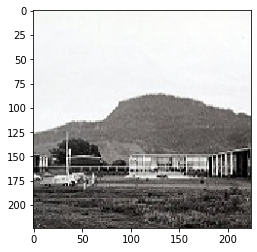

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


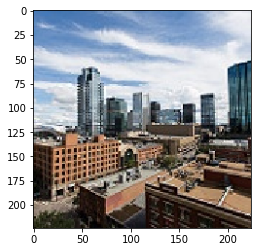

tf.Tensor([0.71157527 0.         0.         0.         0.28842473 0.        ], shape=(6,), dtype=float32)


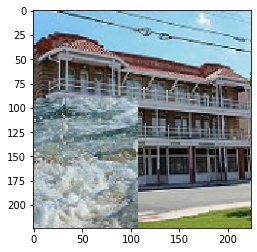

tf.Tensor([0.87197065 0.12802933 0.         0.         0.         0.        ], shape=(6,), dtype=float32)


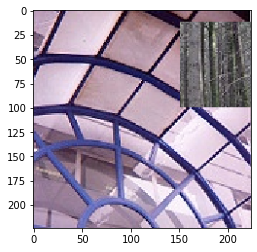

tf.Tensor([0.98652744 0.         0.         0.01347258 0.         0.        ], shape=(6,), dtype=float32)


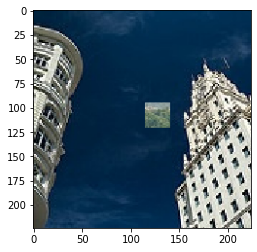

tf.Tensor([0.5515784  0.         0.         0.         0.44842157 0.        ], shape=(6,), dtype=float32)


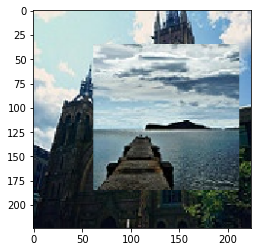

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


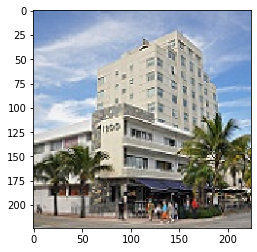

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


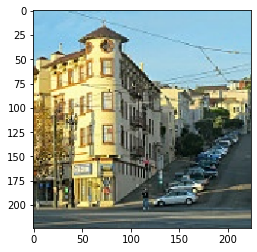

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


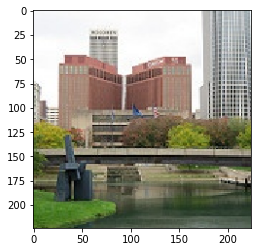

tf.Tensor([0.62665415 0.         0.         0.         0.37334582 0.        ], shape=(6,), dtype=float32)


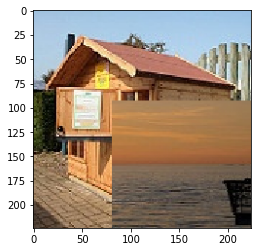

In [14]:
for image, label in zip(images[:10], labels[:10]):
    plt.imshow(image / 255)
    # print(image.shape)
    print(label)
    plt.show()

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((images, labels))

In [16]:
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [17]:
def create_model():
    inputs = keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs)
    x = mobilenetv3(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(N_CLASS)(x)
    x = BatchNormalization()(x)
    outpus = Softmax()(x)
    model = keras.Model(inputs=inputs, outputs=outpus)
    return model

In [18]:
model = create_model()

In [19]:
train_ds = train_ds.shuffle(100).batch(32) 

In [20]:
model.compile(keras.optimizers.Adam(LR), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

hist = model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
439/439 [==============================] - 435s 972ms/step - loss: 1.7111 - accuracy: 0.4361 - val_loss: 1.2093 - val_accuracy: 0.7593
Epoch 2/50
439/439 [==============================] - 413s 940ms/step - loss: 1.6115 - accuracy: 0.5501 - val_loss: 1.2735 - val_accuracy: 0.7000
Epoch 3/50
439/439 [==============================] - 413s 940ms/step - loss: 1.5732 - accuracy: 0.6089 - val_loss: 1.2560 - val_accuracy: 0.7147
Epoch 4/50
439/439 [==============================] - 419s 950ms/step - loss: 1.5540 - accuracy: 0.6295 - val_loss: 1.2069 - val_accuracy: 0.7383
Epoch 5/50
439/439 [==============================] - 411s 936ms/step - loss: 1.5398 - accuracy: 0.6448 - val_loss: 1.1684 - val_accuracy: 0.7650
Epoch 6/50
439/439 [==============================] - 412s 938ms/step - loss: 1.5236 - accuracy: 0.6658 - val_loss: 1.1664 - val_accuracy: 0.7407
Epoch 7/50
439/439 [==============================] - 416s 948ms/step - loss: 1.5086 - accuracy: 0.6868 - val_loss: 1.1782 -

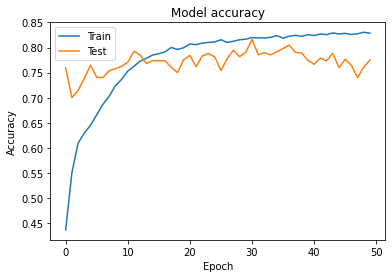

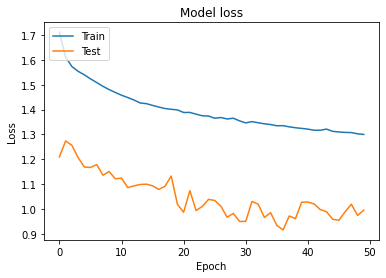

In [21]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
model.save('applying_cutoff_rank_all.h5')

C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [28]:
model8 = tf.keras.models.load_model('applying_cutoff_rank8.h5')